In [ ]:
# Load the Drive helper and mount
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!pip install Bio

     |████████████████████████████████| 269 kB 4.1 MB/s 
     |████████████████████████████████| 2.3 MB 69.5 MB/s 


In [3]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from Bio import SeqIO

ModuleNotFoundError: ignored

In [ ]:
def kmer2seq(kmers):
    """
    Convert kmers to original sequence
    
    Arguments:
    kmers -- str, kmers separated by space.
    
    Returns:
    seq -- str, original sequence.

    """
    kmers_list = kmers.split(" ")
    bases = [kmer[0] for kmer in kmers_list[0:-1]]
    bases.append(kmers_list[-1])
    seq = "".join(bases)
    assert len(seq) == len(kmers_list) + len(kmers_list[0]) - 1
    return seq

In [ ]:
def seq2kmer(seq, k):
    """
    Convert original sequence to kmers
    
    Arguments:
    seq -- str, original sequence.
    k -- int, kmer of length k specified.
    
    Returns:
    kmers -- str, kmers separated by space

    """
    kmer = [seq[x:x+k] for x in range(len(seq)+1-k)]
    kmers = " ".join(kmer)
    return kmer

In [ ]:
import csv

def fpstopd(fpsfile):

    match_loc_list = []

    input_seq_motif = csv.reader(open(fpsfile, "r"))
    input_seq_motif = list(input_seq_motif)

    for match in input_seq_motif[2:]:
        match = str(match).split()
        match_loc_list.append([str(match[1]), int(match[-4])])

    input_seq_motif_pd = (pd.DataFrame.from_records(match_loc_list, columns = ["ID", str(fpsfile)[6:-4]]))
    return input_seq_motif_pd

In [ ]:
cd /content/drive/My Drive/master_thesis/inputs/hg38_msxTm_ENCFF910TAZ/

In [ ]:
find_m_files = ["findm_TATA.fps", "findm_Inr.fps", "findm_CCAAT.fps", "findm_GC.fps"]

record_num = 2067 # number of promoter sequences containing TATA boxes
#record_num = 6405 # number of promoter sequences containing TATA boxes in plants

In [ ]:
from scipy.signal import savgol_filter
def plotpromoterelementenrichment(find_m_files, record_num):
    plt.figure(figsize=(20, 10))
    for file in find_m_files:
        match_loc_array = fpstopd(file)[str(file)[6:-4]]
        bins = np.bincount(match_loc_array, minlength = 300) #all sequences has length of 300
        bins = (np.round(bins / record_num * 100, 2))
        #bins = pd.DataFrame(data=bins, index = range(-250, 50))
        yhat = savgol_filter(bins,21, 4)

        plt.plot(range(-250, 50), yhat, label = file[6:-4])
        

        plt.title("input promoter sequences Core promoter elements' enrichment:")
        plt.ylabel("frequency (%)")
        plt.xlabel("relative position to TTS")
        plt.legend()
        plt.show()

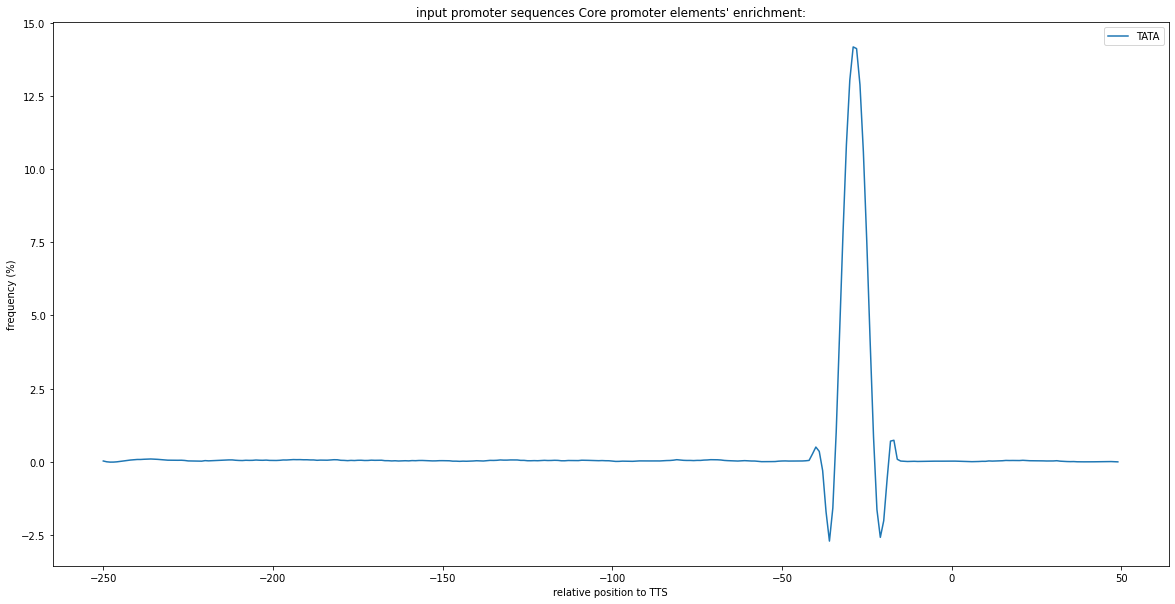

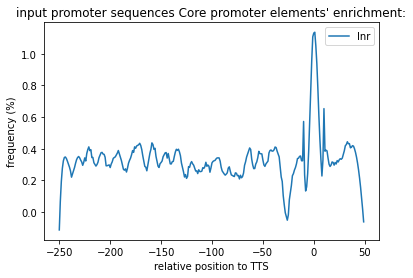

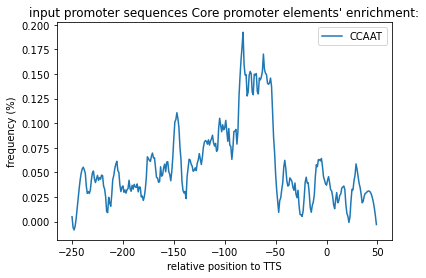

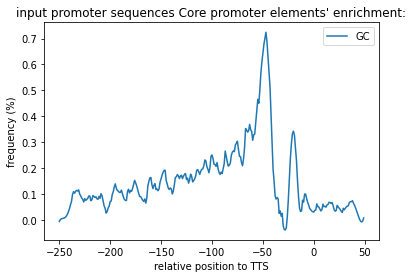

In [ ]:
plotpromoterelementenrichment(find_m_files, record_num)

In [ ]:
def epdparser_fps(fasta_file):
  Promoter_seq_pairs = []
  with open(fasta_file) as handle:
    for value in SeqIO.FastaIO.SimpleFastaParser(handle):
      ID = value[0].split()[0][:]
      Gene_ID = value[0].split()[1][:-2]
      seq = value[1]
      Promoter_seq_pairs.append([ID, Gene_ID, seq])
  epd_df = pd.DataFrame(Promoter_seq_pairs, columns = ("ID", "gene_id", "Sequence"))
  return epd_df

In [ ]:
def epddf_fps_merge(fasta_file, find_m_files):
    epd_df = epdparser_fps(fasta_file)
    for find_m_file in find_m_files:
        fps_df = fpstopd(find_m_file)
        epd_df = pd.merge(left=epd_df, right=fps_df, how = "outer", on = "ID")
    return epd_df

In [ ]:
def createmotiflogos(positive_seqs, start, end):
    from Bio import motifs
    from Bio.Seq import Seq
    print("start: ", start, "end: ", end)
    start += 250
    end += 250        
    seqs = [Seq(seq[start:end]) for seq in positive_seqs]
    m = motifs.create(seqs)
    print(m.counts)
    print(m.consensus)
    print(m.pssm)
    print("\n")
    m.weblogo("/motif_{}_{}_weblogo.png".format(start, end), format='png_print',
                    show_fineprint=False, show_ends=False, color_scheme='color_classic')
    
    return

In [ ]:
def epd_fps_df_count_within(epd_fps_df, start, end):
    for motif in list(epd_fps_df.columns)[3:]:
        subset = epd_fps_df[epd_fps_df[motif] < (end + 250)]
        subset = subset[(start + 250) < subset[motif]]
        percentage = len(subset) / len(epd_fps_df[-epd_fps_df[motif].isna()]) * 100
        print("for", motif,",", "{:.2f}".format(percentage), "% was found within", start, "to", 
              end, "relative to TTS")

In [ ]:
def highly_attended_region_analysis_wrapper(fasta_file, find_m_files, start, end):
    epd_fps_df = epddf_fps_merge(fasta_file, find_m_files)
    epd_fps_df_count_within(epd_fps_df, start, end)
    return epd_fps_df

In [ ]:
epd_fps_df = highly_attended_region_analysis_wrapper("hg38_msxTm.txt", find_m_files, -67, -59)

for TATA , 0.19 % was found within -67 to -59 relative to TTS
for Inr , 2.80 % was found within -67 to -59 relative to TTS
for CCAAT , 6.69 % was found within -67 to -59 relative to TTS
for GC , 5.65 % was found within -67 to -59 relative to TTS


In [ ]:
def subsetmotifs(epd_fps_df, motifs):
    print(epd_fps_df.shape)
    motif_range = {'TATA': [-35, -25], 'Inr': [-5, 6], 'CCAAT': [-100, -60], "GC": [-67, -59]}
    subset = None
    subset_empty = True
    for motif in motifs:
        start, stop = motif_range[motif]
        start, stop = int(start + 250), int(stop + 250)
        rows = epd_fps_df[epd_fps_df[motif].between(start, stop)]
        if subset_empty:
            subset = rows
            subset_empty = False
        else:
            subset = pd.concat([subset,rows])
            print(subset.shape)
            subset = subset[subset.duplicated(keep=False) == True]
    return subset


In [ ]:
subset = subsetmotifs(epd_fps_df, ["GC"])
print("subset len", subset.shape)
final_matrix = pd.read_csv("/content/drive/MyDrive/master_thesis/inputs/hg38_msxTm_ENCFF910TAZ/hg38_msxTm_ENCFF910TAZ.csv")
final_matrix_train, final_matrix_test = train_test_split(final_matrix, test_size=0.2, random_state=1)
print("final matrix len", final_matrix_test.shape)
del(subset["Sequence"])
subset_final_matrix = pd.merge(left=subset, right=final_matrix_test, how = "inner", on = "gene_id", indicator = True).drop_duplicates()
print(subset_final_matrix.shape)

(2067, 7)
subset len (64, 7)
final matrix len (384, 8)
(14, 14)


In [ ]:
from IPython.core.pylabtools import print_figure
from sklearn.model_selection import train_test_split

subset = subsetmotifs(epd_fps_df, ["CCAAT", "GC"])
print("subset len", subset.shape)
final_matrix = pd.read_csv("/content/drive/MyDrive/master_thesis/inputs/hg38_msxTm_ENCFF910TAZ/hg38_msxTm_ENCFF910TAZ.csv")
final_matrix_train, final_matrix_test = train_test_split(final_matrix, test_size=0.2, random_state=1)
print("final matrix len", final_matrix_test.shape)
del(subset["Sequence"])
subset_final_matrix = pd.merge(left=subset, right=final_matrix_test, how = "right", on = "gene_id", indicator = True).drop_duplicates()
print(subset_final_matrix.shape)
subset_final_matrix = subset_final_matrix[subset_final_matrix["_merge"] != "both"]
print(subset_final_matrix.shape)
subset_final_matrix.to_csv("Non_GC_CCAAT_subset.csv")

(2067, 7)
(170, 7)
subset len (4, 7)
final matrix len (384, 8)
(384, 14)
(384, 14)


In [ ]:
cd /content/drive/MyDrive/master_thesis/inputs/hg38_msxTm_ENCFF910TAZ/

/content/drive/MyDrive/master_thesis/inputs/hg38_msxTm_ENCFF910TAZ


generate completely random 300 bp sequences 

In [ ]:
import random

def generaterandomsequence(length, amount):
    BASES = ('A', 'C', 'T', 'G')
    array = np.empty(amount, dtype= object)
    for index, row in enumerate(array):
        array[index] = ''.join(random.choice(BASES) for _ in range(length))
    return array

In [ ]:
random_sequence = generaterandomsequence(300, 384)
np.save("random_seq.npy", random_sequence)

generate random motifs from input sequences

In [ ]:
def generaterandommotifs(positive_seqs, min_len, max_len, amount):
    random_motifs_list = []
    for seqs in positive_seqs:
        motif_per_seqs = random.randrange(5)
        for i in range(0, motif_per_seqs):
            motif_size = random.randrange(min_len, max_len + 1)
            idx = random.randrange(0, len(seqs) - motif_size + 1)    # Randomly select an "idx" such that "idx + substr_len <= len(main_str)".
            random_motifs_list.append(seqs[idx : (idx+motif_size)])
    random_motifs_list = random.sample(random_motifs_list, amount)

    for motifs in random_motifs_list:
        print((motifs+'\n'))


    return random_motifs_list

In [ ]:
from scipy.stats import chi2_contingency

obs = np.array([[2, 15], [5, 4]])
chi2, p, dof, expected = chi2_contingency(obs)
print(p)

0.053578435857270165


In [ ]:
from statsmodels.stats.proportion import proportions_ztest

repressor = np.array([15, 4])
samples = np.array([17, 9])

stat, p_value = proportions_ztest(count=repressor, nobs=samples,  alternative='two-sided')
print(p_value)

0.016624259477849877


In [ ]:
from scipy.stats import fisher_exact

oddsr, p = fisher_exact(np.array([[2, 15], [5, 4]]), alternative="less")
print("pvalue", p)

pvalue 0.5067054738070073
pvalue 0.028276071754332617


In [1]:
ft = [0.979, 0.919, 1.005, 0.931]
pt = [18.169, 18.361, 18.495, 17.711]
kmer = [1.154, 1.067, 1.033, 1.126]

ft_r = [0.262, 0.267, 0.247, 0.277]
pt_r = [-0.349, -0.464, -0.352, -0.387]
kmer_r = [0.023, 0.027, 0.003, -0.001]

pt_p = [23.207, 22.404,22.849]
ft_p = [2.909,2.711, 2.738]
kmer_p = [1.389, 1.276, 1.280]


ft_p_r = [-0.937, -0.749, -0.769]
pt_p_r = [-1.398, -1.373, -1.381]
kmer_p_r = [0.043, 0.094, 0.094]

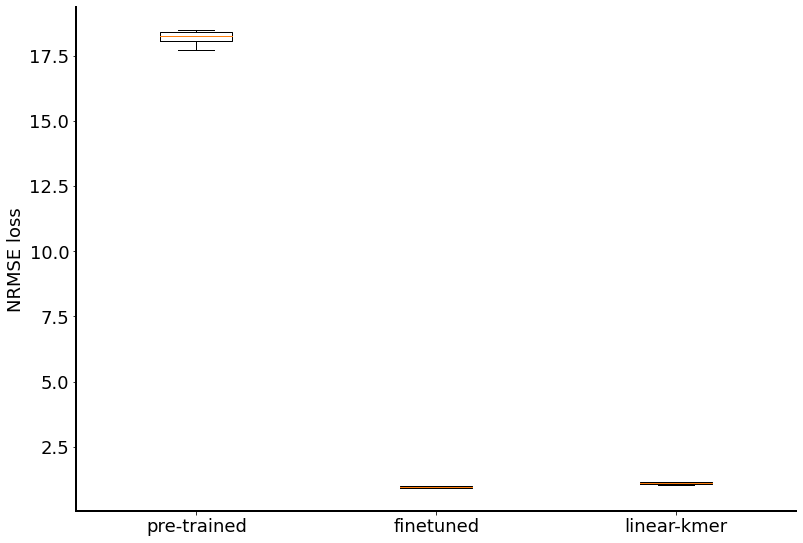

In [10]:
import matplotlib.font_manager as fm
import matplotlib as mpl
from pylab import cm

mpl.rcParams['font.family'] = 'Avenir'
plt.rcParams['font.size'] = 18
plt.rcParams['axes.linewidth'] = 2

colors = cm.get_cmap('tab10', 2)


data = [pt, ft, kmer]
 
fig = plt.figure(figsize =(10, 7))
 
# Creating axes instance
ax = fig.add_axes([0, 0, 1, 1])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
 
# Creating plot
bp = ax.boxplot(data)

ax.set_ylabel("NRMSE loss")
#ax.set_ylabel("R-squared value")


ax.set_xticklabels(['pre-trained', 'finetuned', 'linear-kmer'])
 
# show plot
plt.show()